#  **Hyperparameter Tuning with Optuna (LSTM with Attention + SMOTE)**


## **1. Overview of the Hyperparameter Tuning Process**

This section performs hyperparameter tuning for the LSTM + Attention model using **Optuna**, a powerful optimization framework. Here's a breakdown of what we did:

1. **Setup**: Imported all required libraries and utility functions.
2. **Data Loading**: Loaded the preprocessed and scaled training/validation/test sets (after SMOTE) from the main notebook using: `artifacts/lstm_with_attention/data_for_tuning.pkl`
3. **LSTM Input Preparation**: Reshaped the data into 3D sequences `(samples, timesteps=1, features)` as required by LSTM.
4. **Defined the Optuna Objective Function**:
- Tuned hyperparameters:
  - `lstm_units`: Number of units in LSTM layers
  - `dense_units`: Size of the dense layer
  - `dropout_rate`: Regularization to prevent overfitting
  - `learning_rate`: Learning rate for training
  - `optimizer`: Either `'adam'` or `'rmsprop'`
- Trained the model for **10 epochs** and tracked validation AUC.
- Returned the final AUC score for each trial.
5. **Ran the Tuning Process**:
- Conducted 10 Optuna trials to find the best hyperparameter combination.
- Each trial trained a new model with a unique combination of hyperparameters.

6. **Saved Results**:
- Saved the full tuning history as a CSV file:
  ```
  tuning_results/lstm_with_attention_tuning_trials.csv
  ```


7. **🏆 Exported Best Parameters**:
- Once the best parameters are found, we export them for reuse in the master notebook 📌[`final_experiments.ipynb`](../final_experiments.ipynb) for retraining, test evaluation, and reporting.



This tuning setup allows us to find the most effective hyperparameters while keeping the model lightweight and reducing overfitting risk.



In [38]:
import sys
import os

# Set path to root of the project (adjust if needed)
project_root = os.path.abspath("..")  # one level up
if project_root not in sys.path:
    sys.path.append(project_root)

In [23]:
# tuning/lstm_attention_tuning.ipynb

# Setup
import numpy as np
import pandas as pd
import optuna
import os
import joblib
import tensorflow as tf

from models.lstm_attention_model import build_lstm_attention_model
from training.lstm_attention_trainer import train_lstm_model
from evaluation.metrics import compute_classification_metrics
from evaluation.plots import plot_loss_curve
from utils.callbacks import get_lstm_attention_callbacks
from utils.style_utils import styled_print

# Load saved training/validation/test data from main notebook
X_train_res_scaled, y_train_res, X_val_scaled, y_val, X_test_scaled, y_test = joblib.load(
    "../artifacts/lstm_with_attention/data_for_tuning.pkl"
)


styled_print("🗂️ Loaded training/validation/test sets from: artifacts/lstm_with_attention/data_for_tuning.pkl")

#  Prepare Data for LSTM
X_train_seq = np.expand_dims(X_train_res_scaled.values, axis=1)
X_val_seq   = np.expand_dims(X_val_scaled.values, axis=1)
X_test_seq  = np.expand_dims(X_test_scaled.values, axis=1)
input_shape = (1, X_train_seq.shape[2])

#  Optuna Objective Function
def objective(trial):
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.001, 0.0005])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])

    model = build_lstm_attention_model(
        input_shape=input_shape,
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate) if optimizer_name == "adam" \
                else tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='AUC')])

    history = model.fit(
        X_train_seq, y_train_res,
        validation_data=(X_val_seq, y_val),
        epochs=10,
        batch_size=256,
        verbose=0
    )

    # debugging
    val_auc = history.history.get("val_auc")
    if val_auc is None:
        print("❌ 'val_auc' not found in history. Available keys:", history.history.keys())
        return 0.0
    print(f"[Trial] AUC: {val_auc[-1]} for params: {trial.params}")
    return val_auc[-1]

    #return history.history["val_auc"][-1]

In [24]:
#  Run Tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-03-27 04:30:34,640] A new study created in memory with name: no-name-30b73dce-0dee-41dc-b21c-24dd993f5475


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
[I 2025-03-27 04:31:32,000] Trial 0 finished with value: 0.0 and parameters: {'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:32:00,572] Trial 1 finished with value: 0.0 and parameters: {'lstm_units': 32, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:33:22,595] Trial 2 finished with value: 0.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'optimizer': 'adam'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:33:57,203] Trial 3 finished with value: 0.0 and parameters: {'lstm_units': 32, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:35:17,394] Trial 4 finished with value: 0.0 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'optimizer': 'adam'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:36:04,555] Trial 5 finished with value: 0.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'optimizer': 'adam'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:36:53,274] Trial 6 finished with value: 0.0 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001, 'optimizer': 'adam'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:37:39,175] Trial 7 finished with value: 0.0 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:38:57,966] Trial 8 finished with value: 0.0 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005, 'optimizer': 'adam'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


[I 2025-03-27 04:39:54,215] Trial 9 finished with value: 0.0 and parameters: {'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.0.


❌ 'val_auc' not found in history. Available keys: dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


In [29]:
#  Save trials and best params
os.makedirs("tuning_results", exist_ok=True)
df_trials = study.trials_dataframe()
df_trials.to_csv("tuning_results/lstm_with_attention_tuning_trials.csv", index=False)
styled_print("📁 Tuning trials saved to: tuning_results/lstm_with_attention_tuning_trials.csv")
print("✅ CSV saved at: tuning_results/lstm_with_attention_tuning_trials.csv")

✅ CSV saved at: tuning_results/lstm_with_attention_tuning_trials.csv


## **2. Final Re-training Using Best Hyperparameters**


In this step, we re-train the LSTM + Attention model using the **best hyperparameters** found during Optuna tuning. This re-training uses the full training set (resampled with SMOTE), and we monitor validation performance with metrics like AUC, Recall, and Precision.

8. **Re-train Final Model**: Trained a new LSTM + Attention model using the best hyperparameters (no test evaluation yet).
8. **Model Saving:** Saved the best re-trained model to disk using: `best_model.save("tuning_results/lstm_with_attention_best_model_after_tuning.h5")`

⚠️ **Important**: We still **do not evaluate on the test set** at this stage to avoid data leakage. This model will be used later in the evaluation phase after final training is complete.


In [41]:
styled_print(" Re-training Final LSTM + Attention Model Using Best Parameters (NO test evaluation yet!)")

best_model = build_lstm_attention_model(
    input_shape=input_shape,
    lstm_units=best_params["lstm_units"],
    dense_units=best_params["dense_units"],
    dropout_rate=best_params["dropout_rate"]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]) \
            if best_params["optimizer"] == "adam" else tf.keras.optimizers.RMSprop(learning_rate=best_params["learning_rate"])

best_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Recall(name='Recall'),
        tf.keras.metrics.Precision(name='Precision')
    ]
)

best_history = best_model.fit(
    X_train_seq, y_train_res,
    validation_data=(X_val_seq, y_val),
    epochs=50,
    batch_size=256,
    callbacks=get_lstm_attention_callbacks(),
    verbose=1
)



Epoch 1/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.9816 - Precision: 0.9677 - Recall: 0.8999 - loss: 0.1635 - val_AUC: 0.9735 - val_Precision: 0.0474 - val_Recall: 0.8873 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 2/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9917 - Precision: 0.9665 - Recall: 0.9369 - loss: 0.1143 - val_AUC: 0.9336 - val_Precision: 0.8833 - val_Recall: 0.7465 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 3/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9932 - Precision: 0.9657 - Recall: 0.9461 - loss: 0.1032 - val_AUC: 0.9356 - val_Precision: 0.8438 - val_Recall: 0.7606 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 4/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.9942 - Precision: 0.9670 - Recall: 0.9530 - loss: 0.0952 - val_AUC: 0.8336 - val_Precision: 0.0020 - val_Recall: 1.0000 - val_loss: 3.5629 - learning_rate: 0.0010
Epoch 5/50
1537/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9949 - Precision: 0.9682 - Recall

In [43]:
best_model.save("tuning_results/lstm_with_attention_best_model_after_tuning.h5")

In [46]:
import joblib

# 💾 Save the training history dictionary
joblib.dump(best_history.history, "tuning_results/lstm_with_attention_best_history_after_tuning.pkl")
styled_print("📂 Training history saved to: tuning_results/lstm_with_attention_best_history_after_tuning.pkl")


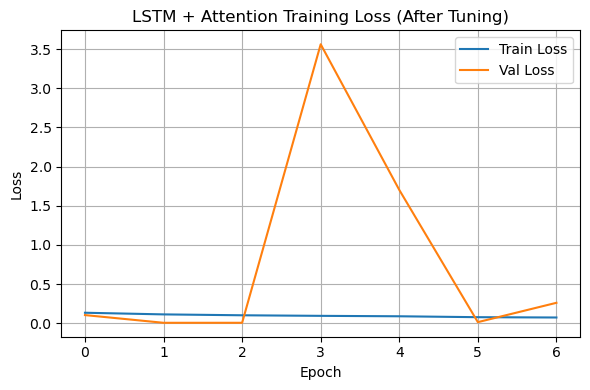

In [44]:
plot_loss_curve(best_history, title="LSTM + Attention Training Loss (After Tuning)")


## **3. Unit Testing**

In [50]:
# 🧪 Class-Based Unit Testing for LSTM with Attention (Advanced)

import unittest

class TestLSTMAttentionTuning(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        cls.X_train_seq = X_train_seq
        cls.X_val_seq = X_val_seq
        cls.input_shape = input_shape
        cls.study = study
        cls.best_history = best_history
        cls.best_params = cls.study.best_trial.params
        cls.saved_model_path = "tuning_results/lstm_with_attention_best_model_after_tuning.h5"
        cls.saved_history_path = "tuning_results/lstm_with_attention_best_history_after_tuning.pkl"

    def test_1_data_shapes(self):
        """Test training and validation data shapes"""
        self.assertEqual(self.X_train_seq.ndim, 3, "X_train_seq should have 3 dimensions (batch, timesteps, features)")
        self.assertEqual(self.X_val_seq.ndim, 3, "X_val_seq should have 3 dimensions (batch, timesteps, features)")

    def test_2_optuna_best_params(self):
        """Check if Optuna tuning found expected parameters"""
        required_params = ["lstm_units", "dense_units", "dropout_rate", "learning_rate", "optimizer"]
        for param in required_params:
            self.assertIn(param, self.best_params, f"Optuna best params missing '{param}'")

    def test_3_training_history_metrics(self):
        """Verify retrained model has proper metrics"""
        self.assertIn("val_AUC", self.best_history.history, "Re-trained model history missing 'val_AUC'")
        self.assertGreater(len(self.best_history.history["val_AUC"]), 0, "val_AUC history is empty")

    def test_4_model_saved(self):
        """Confirm the best model (.h5) is correctly saved"""
        self.assertTrue(os.path.exists(self.saved_model_path), "Best model file (.h5) not found.")

    def test_5_history_saved(self):
        """Ensure the training history (.pkl) is correctly saved"""
        self.assertTrue(os.path.exists(self.saved_history_path), "Training history file (.pkl) not found.")

# Run Unit Tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestLSTMAttentionTuning)
unittest.TextTestRunner(verbosity=2).run(suite)


test_1_data_shapes (__main__.TestLSTMAttentionTuning.test_1_data_shapes)
Test training and validation data shapes ... ok
test_2_optuna_best_params (__main__.TestLSTMAttentionTuning.test_2_optuna_best_params)
Check if Optuna tuning found expected parameters ... ok
test_3_training_history_metrics (__main__.TestLSTMAttentionTuning.test_3_training_history_metrics)
Verify retrained model has proper metrics ... ok
test_4_model_saved (__main__.TestLSTMAttentionTuning.test_4_model_saved)
Confirm the best model (.h5) is correctly saved ... ok
test_5_history_saved (__main__.TestLSTMAttentionTuning.test_5_history_saved)
Ensure the training history (.pkl) is correctly saved ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.008s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>